In [11]:
import pandas as pd

In [12]:
df = pd.read_sas('data.sas7bdat')
# decode all object columns that are bytes to strings
for col in df.select_dtypes(include=['object']).columns:
    if df[col].apply(lambda x: isinstance(x, bytes)).any():
        df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

In [13]:
df.head()

,randhosp_id,randpat_id,pretrialexp,country,trialphase,phase,itt_treat,age,gender,deathcode,...,censor18,surv18,plan18,UKextra,disab_unknown6,vital_and_disabunknown6,disab_unknown18,vital_and_disabunknown18,treatment,haltcode
0,090,00001,2.0,UK,Open,2.0,0.0,81.0,1.0,E4,...,0.0,158.0,1.0,2.0,0.0,0.0,0.0,0.0,rt-PA,NaN
1,012,00002,1.0,SWEDEN,Open,2.0,1.0,92.0,1.0,NaN,...,1.0,548.0,1.0,2.0,0.0,0.0,0.0,0.0,Placebo,NaN
2,043,00003,1.0,POLAND,Open,2.0,1.0,75.0,1.0,NaN,...,1.0,548.0,1.0,2.0,0.0,0.0,0.0,0.0,Placebo,NaN
3,077,00004,2.0,UK,Open,2.0,0.0,60.0,1.0,NaN,...,1.0,548.0,1.0,2.0,0.0,0.0,0.0,0.0,rt-PA,I63
4,043,00005,1.0,POLAND,Open,2.0,0.0,88.0,1.0,NaN,...,NaN,NaN,2.0,2.0,0.0,0.0,NaN,NaN,rt-PA,NaN


In [14]:
df['deathcode'].value_counts()

deathcode
E1    536
E4    307
E3    194
E8     79
E9     77
E2     47
E7     21
Name: count, dtype: int64

In [15]:
# Keep only the rows where deathcode is NaN, e1 (cerebrovascular) or e3 (cardiovascular)
df = df[df['deathcode'].isna() | (df['deathcode'] == 'E1') | (df['deathcode'] == 'E3')]
df['deathcode'] = (~df['deathcode'].isna()).astype(bool)

Choose the rows with no randomisation violation

In [16]:
df['randvioltype'].value_counts()

randvioltype
Not independent in ADL                 15
Pre-randomisation low dose heparin     15
Haemorrhage on R scan                   1
Advanced ischaemic change on R scan     1
Name: count, dtype: int64

In [17]:
df = df[df['randvioltype'].isna()]
len(df)

2472

# Variable explanations

In [18]:
from scripts.columns import GENERAL, GENERAL_FORMATS, RAND_FORM, RAND_FORM_FORMATS
from scripts.preprocess import preprocess

SELECTED_COLS = GENERAL + RAND_FORM + ['deathcode']
FORMATS = GENERAL_FORMATS | RAND_FORM_FORMATS

df = df[SELECTED_COLS]

In [ ]:
df = df[(df['livealone_rand'] == 1.0) | (df['indepinadl_rand'] == 2.0)]

In [20]:
df, stats_df = preprocess(df, SELECTED_COLS, GENERAL_FORMATS | RAND_FORM_FORMATS | {'deathcode': bool})

df.head()

,age,itt_treat,weight,glucose,sbprand,dbprand,weight,glucose,gcs_score_rand,nihss,...,visuospat_rand_Unknown,visuospat_rand_Yes,brainstemsigns_rand_Unknown,brainstemsigns_rand_Yes,otherdeficit_rand_Unknown,otherdeficit_rand_Yes,stroketype_Other,stroketype_PACI,stroketype_POCI,stroketype_TACI
1,1.105326,1.0,-0.165254,-0.559246,0.585424,0.714734,-0.165254,-0.559246,-0.308792,0.964793,...,True,False,False,False,False,False,False,False,False,True
2,-0.345081,1.0,-0.026895,-0.559246,-1.506199,-0.869189,-0.026895,-0.559246,0.705252,-1.093691,...,False,True,False,False,False,False,False,True,False,False
3,-1.624852,0.0,-0.303614,-0.955829,-1.171539,-0.593724,-0.303614,-0.955829,0.198230,0.229620,...,False,True,False,False,False,False,False,False,False,True
4,0.764054,0.0,-1.064590,-0.162664,0.878251,0.508136,-1.064590,-0.162664,-0.308792,-0.799622,...,False,False,False,False,False,False,False,True,False,False
9,1.105326,1.0,-0.718692,NaN,0.710922,0.370403,-0.718692,NaN,0.705252,0.817758,...,False,True,False,False,False,True,False,False,False,True


In [21]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (e.g., 80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Optionally, display the shapes of the splits
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (726, 52)
Test shape: (182, 52)


In [22]:
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold
import numpy as np

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

X_train = df_train.drop(columns=['deathcode']).values
y_train = df_train['deathcode'].values
X_test = df_test.drop(columns=['deathcode']).values
y_test = df_test['deathcode'].values

kf = StratifiedKFold(n_splits=5, shuffle=True)
fold_aucs = []
fold_accs = []
models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    _X_train, _X_val = X_train[train_idx], X_train[val_idx]
    _y_train, _y_val = y_train[train_idx], y_train[val_idx]
    
    clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, use_label_encoder=False, eval_metric="logloss")
    clf.fit(_X_train, _y_train, eval_set=[(_X_val, _y_val)], verbose=False)
    models.append(clf)
    
    y_val_pred_proba = clf.predict_proba(_X_val)[:, 1]
    y_val_pred = clf.predict(_X_val)
    
    from sklearn.metrics import roc_auc_score, accuracy_score
    auc = roc_auc_score(_y_val, y_val_pred_proba)
    acc = accuracy_score(_y_val, y_val_pred)
    fold_aucs.append(auc)
    fold_accs.append(acc)
    print(f"Fold {fold+1}: AUC = {auc:.3f}, Accuracy = {acc:.3f}")

print(f"\nMean AUC: {np.mean(fold_aucs):.3f} ± {np.std(fold_aucs):.3f}")
print(f"Mean Accuracy: {np.mean(fold_accs):.3f} ± {np.std(fold_accs):.3f}")

# For further use, you can pick the last trained model or retrain on all data
clf = models[-1]

Fold 1: AUC = 0.718, Accuracy = 0.692
Fold 2: AUC = 0.763, Accuracy = 0.703
Fold 3: AUC = 0.792, Accuracy = 0.800
Fold 4: AUC = 0.734, Accuracy = 0.745
Fold 5: AUC = 0.762, Accuracy = 0.683

Mean AUC: 0.754 ± 0.026
Mean Accuracy: 0.725 ± 0.043


/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:35:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:35:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:35:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:35:23] WARNING: /Users/runner/work/xgboost/xgb

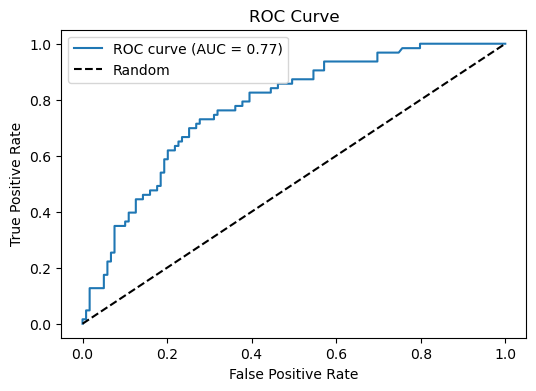

Accuracy: 0.72


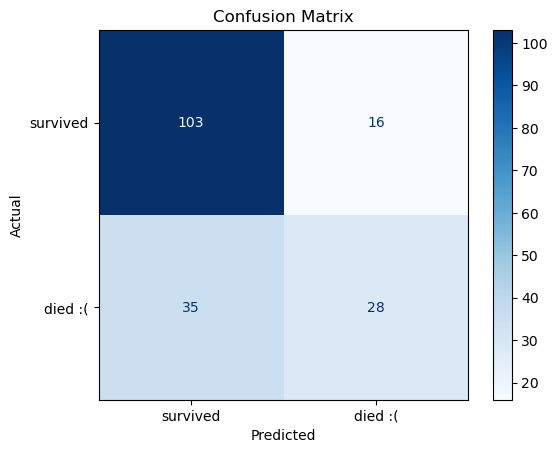

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities and classes
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["survived", "died :("])
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Top 20 most informative columns:
                                   feature  importance
                                   konprob    0.101337
                   gcs_eye_rand_To command    0.079302
                    visuospat_rand_Unknown    0.056908
                         liftarms_rand_Yes    0.050140
                       hemianopia_rand_Yes    0.043553
                        dysphasia_rand_Yes    0.038825
                                pred_nihss    0.036315
gcs_motor_rand_Localises movements to pain    0.034208
                     gcs_motor_rand_Normal    0.034017
                        visuospat_rand_Yes    0.031205
                   hemianopia_rand_Unknown    0.028180
                                       age    0.028026
                                   glucose    0.027826
                         antiplat_rand_Yes    0.027788
                     otherdeficit_rand_Yes    0.027559
                                   sbprand    0.026989
                                

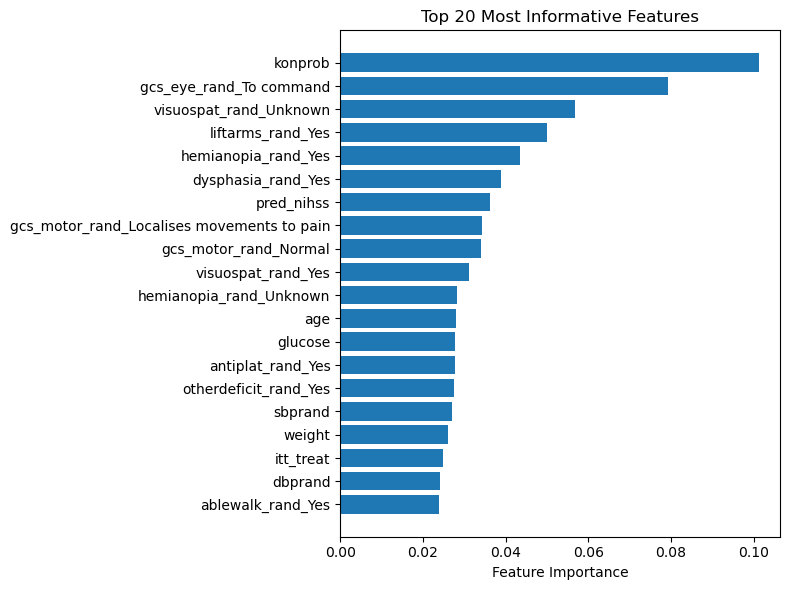

In [24]:
# Find the most informative columns using feature importances from the trained XGBoost model

import pandas as pd
import numpy as np

# Get feature importances from the last trained model
importances = clf.feature_importances_
feature_names = list(df.columns)
feature_names.remove('deathcode')

# Create a DataFrame for easy viewing
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Display the top 20 most informative columns
print("Top 20 most informative columns:")
print(feat_imp_df.head(20).to_string(index=False))

# Optionally, plot the top 20
plt.figure(figsize=(8, 6))
plt.barh(feat_imp_df.head(20)['feature'][::-1], feat_imp_df.head(20)['importance'][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Informative Features")
plt.tight_layout()
plt.show()
